In [100]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle

%matplotlib inline

In [72]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

In [92]:
def generate_word2vec_text8(saveTo = 'models/text8.model'):
    sentences = word2vec.Text8Corpus('data/text8')
    model = word2vec.Word2Vec(sentences, size=EMBEDDING_DIM)
    model.save(saveTo)
    model.wv.save_word2vec_format(saveTo + '.bin', binary=True)
    print('DONE! Saved to', saveTo)

def generate_glove_text8(saveTo = 'models/glovetext8.model'):
    import itertools
    sentences = list(itertools.islice(word2vec.Text8Corpus('data/text8'),None))
    corpus = Corpus()
    corpus.fit(sentences, window=10)
    glove = Glove(no_components=EMBEDDING_DIM,learning_rate=0.05)
    glove.fit(corpus.matrix, epochs=30,no_threads=4,verbose=True)
    glove.add_dictionary(corpus.dictionary)
    glove.save(saveTo)
    print('DONE! Saved to', saveTo)
    
def load_data(word_count, emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 6]
    # Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
#     data,patterns = remove_empty_patterns(data,patterns)
    return data

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(".*?\[(.*?)\]","",text) # Take out any [action] text in the transcript
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]


In [93]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data = load_data(3, emotional_mapping)
df = data[['text','emotion_code']]
df.head()

,text,emotion_code
2,is there a problem,3
5,well what's the problem let me change it,3
6,what i'm getting an id this is why i'm here my...,4
7,how am i supposed to get an id without an id h...,4
8,i'm here to get an id,4


## Parameter

In [94]:
# DATASET
TEST_SIZE      = 0.2

# EMBEDDING
MAX_NUM_WORDS  = 2954 # 2500, 2000, 2700
EMBEDDING_DIM  = 200
MAX_SEQ_LENGTH = 100
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.1

## Preprocessing

In [95]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)

In [96]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer()#num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

length = max_length(x_train)
word_index = tokenizer.word_index

result = [len(x.split()) for x in x_train]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))

print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 100 / min length: 3 / mean length: 13 / limit length: 100
vocabulary size: 2926 / limit: 2954


In [97]:
len(data), len(y_train)

(5116, 5116)

# Embeddings

In [98]:
def create_glove_embeddings(data = None, use_text8 = False, LEARNING_RATE=0.05, EPOCHS=30, NO_THREADS=4):
    model = None
    if(use_text8):
        model = Glove.load('models/glovetext8.model')
    else:
        if(data != None):
            corpus = Corpus()
            corpus.fit(data, window=10)
            model = Glove(no_components=EMBEDDING_DIM,learning_rate=LEARNING_RATE)
            model.fit(corpus.matrix, epochs=EPOCHS,no_threads=NO_THREADS,verbose=True)
            model.add_dictionary(corpus.dictionary)
        else:
            print('No data found. Using text8 Corpus')
            model = Glove.load('models/glovetext8.model')
    
    embeddings_index = {}
    for word,index in model.dictionary.items():
        embeddings_index[word] = model.word_vectors[index]
    
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix], trainable=True)
    
def create_word2vec_embeddings(data = None, use_text8 = False):
    model = None
    if(use_text8):
        model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    else:
        if(data != None):  
            model = word2vec.Word2Vec(data, size=EMBEDDING_DIM)
        else:
            print('No data found. Using text8 Corpus')
            model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    
    embeddings_index = {}
    for word in model.wv.index2word:
        embeddings_index[word] = model[word]
        
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length = MAX_SEQ_LENGTH,
                    weights= [embedding_matrix], trainable=True)

# Model Definition

## Training

In [88]:
embedding_data = [x.split() for x in x_train]
model = word2vec.Word2Vec(embedding_data, size=EMBEDDING_DIM)
emb_layers = [create_word2vec_embeddings(use_text8=True),
              create_word2vec_embeddings(embedding_data),
              create_glove_embeddings(use_text8=True),
              create_glove_embeddings(embedding_data)
             ]

/Users/roblescoulter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/Users/roblescoulter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [89]:
print(len(data),len(y_train))

5116 5116


In [90]:
import cnn_model

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    
    X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)
    
    emb_layer = None
    if USE_GLOVE:
        emb_layer = emb_layers[2] #create_word2vec_embeddings(result)
        
    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, labels,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)

Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2954
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 4604 samples, validate on 512 samples
Epoch 1/40
4604/4604 [==============================] - 6s 1ms/step - loss: -15.3636 - acc: 0.1503 - val_loss: -22.9391 - val_acc: 0.1250

Epoch 00001: val_loss improved from inf to -22.93910, saving model to model-1.h5
Epoch 2/40
4604/4604 [==============================] - 6s 1ms/step - loss: -23.1032 - acc: 0.1466 - val_loss: -23.3033 - val_acc: 0.1250

Epoch 00002: val_loss improved from -22.93910 to -23.30326, saving model to model-1.h5
Epoch 3/40
4604/4604 [==============================] - 5s 1ms/step - loss: -23.4342 - acc: 0.1466 - val_loss: -23.6008 - val_acc: 0.1250

Epoch 00003: val_loss improved from -23.30326 to -23.60085, saving model to model-1

4604/4604 [==============================] - 5s 1ms/step - loss: -24.3968 - acc: 0.1466 - val_loss: -24.4068 - val_acc: 0.1250

Epoch 00037: val_loss did not improve from -24.40705
Epoch 38/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3968 - acc: 0.1466 - val_loss: -24.4068 - val_acc: 0.1250

Epoch 00038: val_loss did not improve from -24.40705
Epoch 39/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3968 - acc: 0.1466 - val_loss: -24.4068 - val_acc: 0.1250

Epoch 00039: val_loss did not improve from -24.40705
Epoch 40/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3968 - acc: 0.1466 - val_loss: -24.4068 - val_acc: 0.1250

Epoch 00040: val_loss did not improve from -24.40705
Running iteration 2/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2954
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#


Epoch 00034: val_loss improved from -24.40428 to -24.40430, saving model to model-2.h5
Epoch 35/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3944 - acc: 0.1466 - val_loss: -24.4045 - val_acc: 0.1250

Epoch 00035: val_loss improved from -24.40430 to -24.40446, saving model to model-2.h5
Epoch 36/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3946 - acc: 0.1466 - val_loss: -24.4046 - val_acc: 0.1250

Epoch 00036: val_loss improved from -24.40446 to -24.40464, saving model to model-2.h5
Epoch 37/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3948 - acc: 0.1466 - val_loss: -24.4048 - val_acc: 0.1250

Epoch 00037: val_loss improved from -24.40464 to -24.40483, saving model to model-2.h5
Epoch 38/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3950 - acc: 0.1466 - val_loss: -24.4050 - val_acc: 0.1250

Epoch 00038: val_loss improved from -24.40483 to -24.40503, saving model to model-2.h5
Epoc


Epoch 00031: val_loss did not improve from -24.40653
Epoch 32/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3961 - acc: 0.1466 - val_loss: -24.4061 - val_acc: 0.1250

Epoch 00032: val_loss did not improve from -24.40653
Epoch 33/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3962 - acc: 0.1466 - val_loss: -24.4063 - val_acc: 0.1250

Epoch 00033: val_loss did not improve from -24.40653
Epoch 34/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3964 - acc: 0.1466 - val_loss: -24.4064 - val_acc: 0.1250

Epoch 00034: val_loss did not improve from -24.40653
Epoch 35/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3965 - acc: 0.1466 - val_loss: -24.4066 - val_acc: 0.1250

Epoch 00035: val_loss improved from -24.40653 to -24.40657, saving model to model-3.h5
Epoch 36/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3967 - acc: 0.1466 - val_loss: -24.4067 - val_acc: 0.1250



Epoch 28/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3952 - acc: 0.1466 - val_loss: -24.4053 - val_acc: 0.1250

Epoch 00028: val_loss improved from -24.40506 to -24.40527, saving model to model-4.h5
Epoch 29/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3956 - acc: 0.1466 - val_loss: -24.4057 - val_acc: 0.1250

Epoch 00029: val_loss improved from -24.40527 to -24.40565, saving model to model-4.h5
Epoch 30/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3957 - acc: 0.1466 - val_loss: -24.4060 - val_acc: 0.1250

Epoch 00030: val_loss improved from -24.40565 to -24.40602, saving model to model-4.h5
Epoch 31/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3961 - acc: 0.1466 - val_loss: -24.4062 - val_acc: 0.1250

Epoch 00031: val_loss improved from -24.40602 to -24.40617, saving model to model-4.h5
Epoch 32/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3964 - acc:


Epoch 00024: val_loss did not improve from -24.40217
Epoch 25/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3922 - acc: 0.1466 - val_loss: -24.4022 - val_acc: 0.1250

Epoch 00025: val_loss improved from -24.40217 to -24.40221, saving model to model-5.h5
Epoch 26/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3923 - acc: 0.1466 - val_loss: -24.4024 - val_acc: 0.1250

Epoch 00026: val_loss improved from -24.40221 to -24.40241, saving model to model-5.h5
Epoch 27/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3926 - acc: 0.1466 - val_loss: -24.4026 - val_acc: 0.1250

Epoch 00027: val_loss improved from -24.40241 to -24.40263, saving model to model-5.h5
Epoch 28/40
4604/4604 [==============================] - 5s 1ms/step - loss: -24.3928 - acc: 0.1466 - val_loss: -24.4029 - val_acc: 0.1250

Epoch 00028: val_loss improved from -24.40263 to -24.40287, saving model to model-5.h5
Epoch 29/40
4604/4604 [===============

In [101]:
with open('history/glovetext8.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Evaluation 

In [102]:
histories = pickle.load(open('history/glovetext8.pkl', 'rb'))

In [103]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	-24.3964 loss / 0.1466 acc
Validation: 	-24.4064 loss / 0.1250 acc


In [105]:

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

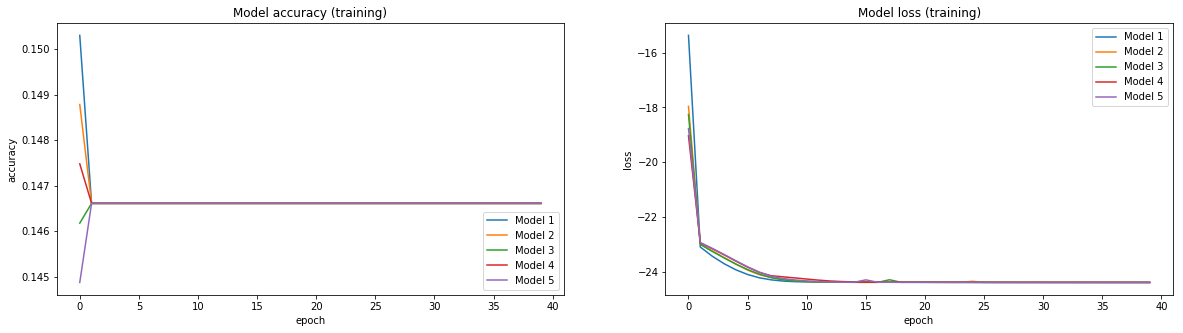

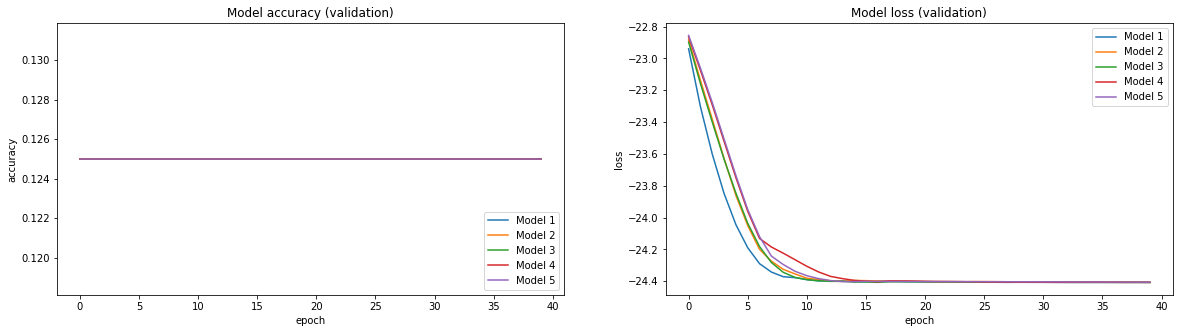

In [106]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')